In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import datetime
import random
import torch.nn.utils as utils

Get Data

In [2]:
def get_data(path):
    image_extensions = ['.jpg']
    image_names = []
    for filename in os.listdir(path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

In [3]:
path = '/Users/ayanfe/Documents/Datasets/animefaces256cleaner'
path1 = '/Users/ayanfe/Documents/Code/Diffusion-Model/model/model.pth'
model_two = '/Users/ayanfe/Documents/Code/Diffusion-Model/model/model_fixed_10000.pth'
model_three = '/Users/ayanfe/Documents/Code/Diffusion-Model/weights/waifu-diffusion-lts_200-30000.pth'
image_names = get_data(path)
print(len(image_names))

92219


In [4]:
timesteps = 200

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * ((x_0 - 127.5)/127.5) + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return torch.randint(0, timesteps,(num,), dtype=torch.int32)

def reshape_img(img,size = (64,64)):
    data = cv2.resize(img,size)
    data = np.transpose(data,(2,0,1))
    return data

Visualize the output image at some timesteps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


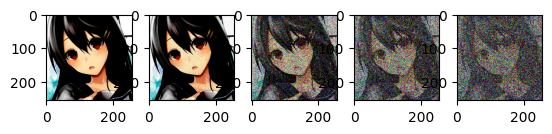

In [5]:
# Let us visualize the output image at a few timestamps
sample_data = plt.imread(path+'/'+image_names[0])

for index, i in enumerate([0,10, 100, 150, 199]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_data, 0), np.array([i,]))
    plt.subplot(1, 5, index+1)
    plt.imshow(np.squeeze(noisy_im,0))
    
plt.show()

In [6]:
def ddim(x_t, pred_noise, t, sigma_t):
    #alpha_t_bar = np.take(alpha_bar, t)
    #alpha_t_minus_one = np.take(alpha, t-1)
    alpha_t_bar = np.take(alpha_bar, t.astype(int))  # Cast t to integer before using np.take
    alpha_t_minus_one = np.take(alpha, (t - 1).astype(int))  # Similarly, cast t-1 to integer

    #alpha_t_bar = torch.from_numpy(alpha_t_bar)
    #alpha_t_minus_one = torch.from_numpy(alpha_t_minus_one)

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def inference(model, device, num_samples=5):
    # Define number of inference loops to run
    inference_timesteps = 10
    
    # Create a range of inference steps that the output should be sampled at
    inference_range = range(0, timesteps, timesteps // inference_timesteps)
    
    x = torch.randn(1, 3, 64, 64).to(device)  # Initialize a random input image on GPU
    img_list = []
    img_list.append(np.squeeze(x.cpu().numpy(), 0))  # Append the initial image
    
    # Iterate over inference_timesteps
    for i in range(inference_timesteps):
        t = np.expand_dims(inference_range[i], 0)
        t = torch.from_numpy(t).type(torch.float32).to(device)
        t = torch.reshape(t, (-1, 1)).type(torch.float32)
        
        pred_noise = model(x, t).detach().to(device)  # Obtain predicted noise
        
        x = ddim(x.cpu().detach().numpy(), pred_noise.cpu().detach().numpy(), t.cpu().detach().numpy(), 0)  # Perform denoising using DDIM
        x = torch.from_numpy(x).type(torch.float32).to(device)  # Transfer denoised image back to GPU
        img_list.append(np.squeeze(x.cpu().detach().numpy(), 0))  # Append the denoised image
    
    # Visualize the final denoised image
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [9]:
#start = 60001

start = 1
img_length = len(image_names)
data_length = 30000
data_idx = list(range(0,data_length+32))
random.shuffle(data_idx)


def training_loop(n_epochs, optimizer, model, loss_fn, device, accumulation_steps=1, 
                  epoch_start = 0, batch_size = 64, max_grad_norm=1.0, repeats = 5):
    global start
    with torch.autograd.set_detect_anomaly(True):
        for epoch in range(epoch_start, n_epochs + 1):
            loss_train = 0.0
            accumulated_loss = 0.0
            loss_mae = 0.0
            random.shuffle(data_idx)
            # Use tqdm function for the progress bar
            with tqdm(range(start, (repeats*data_length)//batch_size), desc=f'Epoch {epoch}', unit=' steps') as pbar:
                st = 0
                for x in pbar:
                    # Training loop code
                    sp = st + batch_size
                    if sp > data_length:
                        st = 0
                        sp = st + batch_size
                    img_arr = []
                    for i in range(st,sp):
                        img = plt.imread(path + '/' + image_names[data_idx[i]])
                        img = reshape_img(img)
                        img = np.expand_dims(img, 0)
                        img_arr.append(img)
                    st+= batch_size
                    
                    t = generate_timestamp(0, batch_size)
                    t = torch.reshape(t, (-1, 1)).type(torch.float32)
                    
                    imgs, noise = forward_noise(None, np.squeeze(np.array(img_arr)), t)
                    
                    imgs = torch.from_numpy(imgs).type(torch.float32).to(device)
                    noise = torch.from_numpy(noise).type(torch.float32).to(device)
                    t = t.to(device)
                    
                    outputs = model(imgs, t)
                    
                    loss = loss_fn(outputs, noise)
                    
                    # Perform gradient accumulation
                    accumulated_loss += loss / accumulation_steps
                    
                    if x % accumulation_steps == 0:
                        accumulated_loss.backward()

                        # Clip gradients
                        utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        
                        optimizer.step()
                        optimizer.zero_grad()
                        accumulated_loss = 0.0  # Reset accumulated loss
                    
                    loss_train += loss.item()
                    outputs.detach_()
                    pbar.set_postfix(loss=loss.item())
                
            avg_loss_epoch = loss_train / ((repeats*data_length)//batch_size)
            with open("waifu-diffusion-lts_200-30000-loss.txt", "a") as file:
                file.write(f"Epoch {epoch}: Average Loss: {avg_loss_epoch}\n")
            
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / ((repeats*data_length)//batch_size)))
            inference(model, device)
            #torch.save(model.state_dict(), path1)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_three)
            


In [10]:
from unet import Unet

model = Unet()
#model.load_state_dict(torch.load(model_two))
device = torch.device("mps")
model.to(device)
optimizer = optim.AdamW(model.parameters(),lr=0.0005)  #  <3>
checkpoint = torch.load(model_three)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
print(epoch)

46


Total parameters:  8287437


Epoch 51: 100%|█████████████| 2342/2342 [38:56<00:00,  1.00 steps/s, loss=0.116]


2024-03-26 00:24:54.617321 Epoch 51, Training loss 0.08921954360907015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


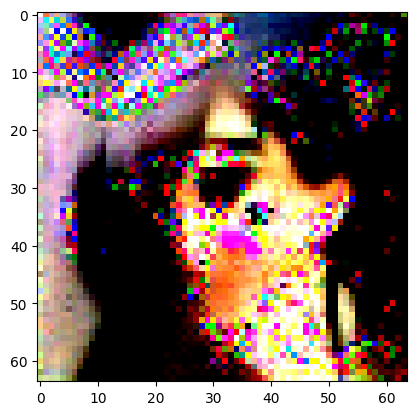

Epoch 52: 100%|██████████████| 2342/2342 [38:27<00:00,  1.02 steps/s, loss=0.12]


2024-03-26 01:03:22.474381 Epoch 52, Training loss 0.08992868727069099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


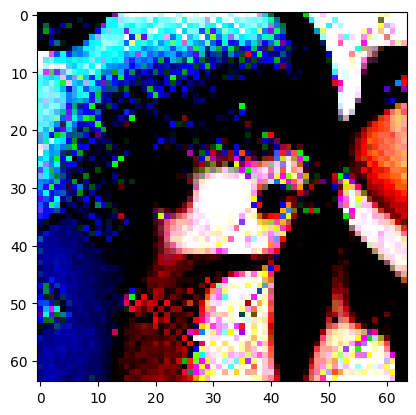

Epoch 53: 100%|█████████████| 2342/2342 [38:18<00:00,  1.02 steps/s, loss=0.106]


2024-03-26 01:41:41.896220 Epoch 53, Training loss 0.08948346521551162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


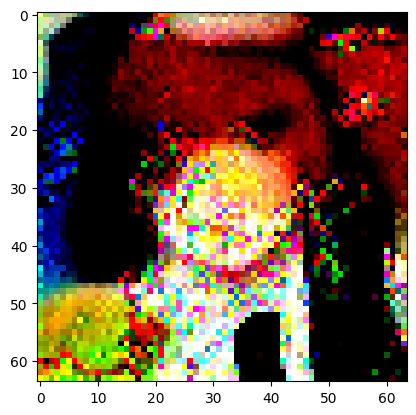

Epoch 54: 100%|████████████| 2342/2342 [38:22<00:00,  1.02 steps/s, loss=0.0979]


2024-03-26 02:20:04.737359 Epoch 54, Training loss 0.08913666690408395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


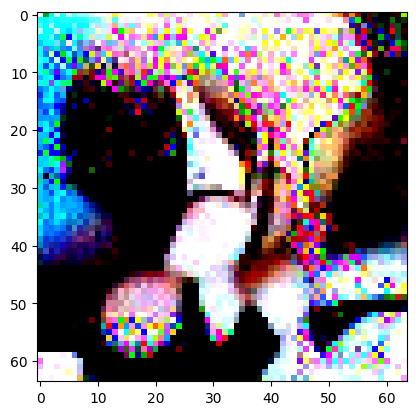

Epoch 55: 100%|█████████████| 2342/2342 [38:25<00:00,  1.02 steps/s, loss=0.114]


2024-03-26 02:58:31.053428 Epoch 55, Training loss 0.0892235903062222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


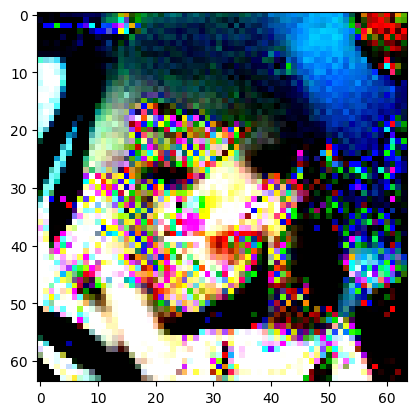

Epoch 56: 100%|█████████████| 2342/2342 [38:23<00:00,  1.02 steps/s, loss=0.092]


2024-03-26 03:36:55.365869 Epoch 56, Training loss 0.08883676223688995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


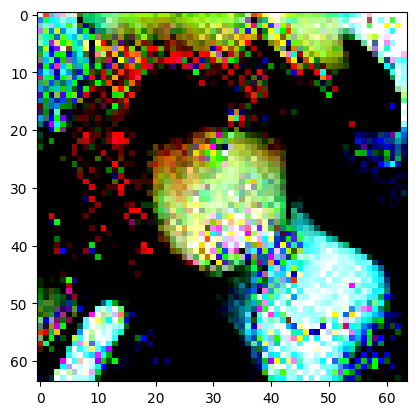

Epoch 57: 100%|████████████| 2342/2342 [38:21<00:00,  1.02 steps/s, loss=0.0888]


2024-03-26 04:15:17.763411 Epoch 57, Training loss 0.08953486687280762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


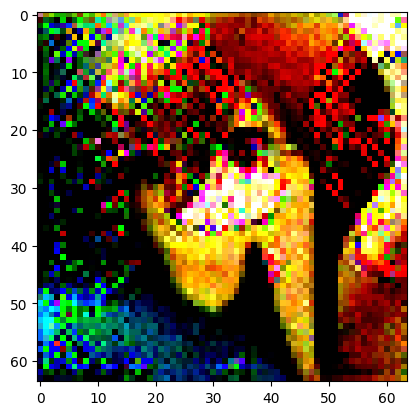

Epoch 58: 100%|████████████| 2342/2342 [38:16<00:00,  1.02 steps/s, loss=0.0765]


2024-03-26 04:53:35.064704 Epoch 58, Training loss 0.08906828446573699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


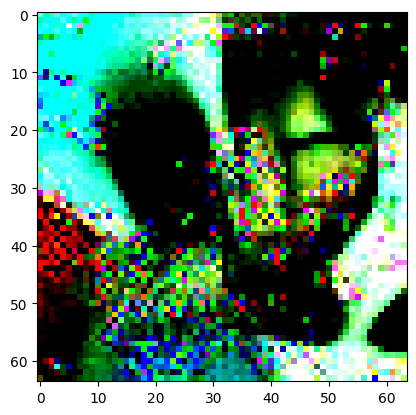

Epoch 59: 100%|████████████| 2342/2342 [38:23<00:00,  1.02 steps/s, loss=0.0702]


2024-03-26 05:31:59.388315 Epoch 59, Training loss 0.08867922687773465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


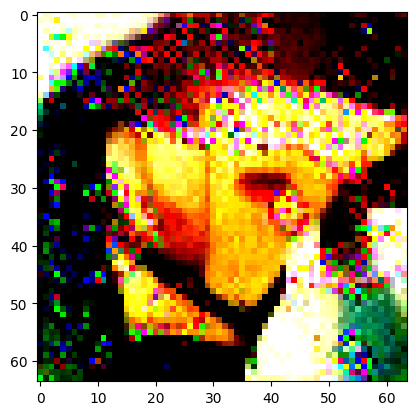

Epoch 60: 100%|█████████████| 2342/2342 [38:25<00:00,  1.02 steps/s, loss=0.089]


2024-03-26 06:10:25.767956 Epoch 60, Training loss 0.08908354946361664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


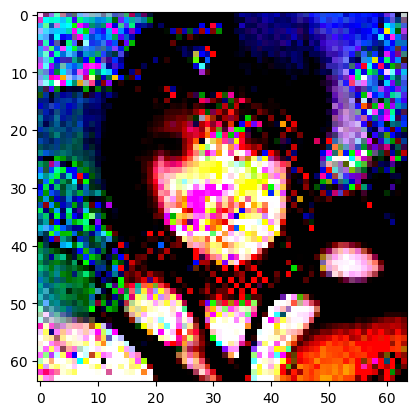

Epoch 61: 100%|█████████████| 2342/2342 [38:25<00:00,  1.02 steps/s, loss=0.069]


2024-03-26 06:48:52.530023 Epoch 61, Training loss 0.08947224577795833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


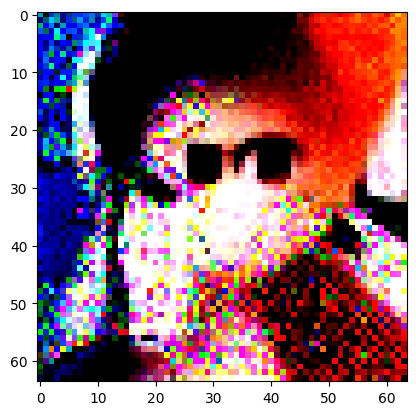

Epoch 62: 100%|█████████████| 2342/2342 [38:21<00:00,  1.02 steps/s, loss=0.111]


2024-03-26 07:27:14.660490 Epoch 62, Training loss 0.08907495189745916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


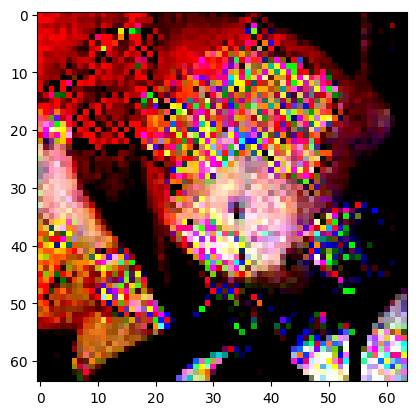

Epoch 63: 100%|████████████| 2342/2342 [38:10<00:00,  1.02 steps/s, loss=0.0792]


2024-03-26 08:05:25.456070 Epoch 63, Training loss 0.08874753265428177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


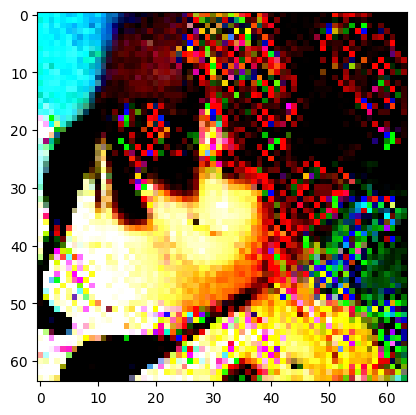

Epoch 64:   4%|▌             | 93/2342 [01:30<36:50,  1.02 steps/s, loss=0.0682]

In [ ]:
print("Total parameters: ",count_parameters(model))
loss_fn = nn.MSELoss()  #  <4>

training_loop(  # <5>
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    epoch_start = 51
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


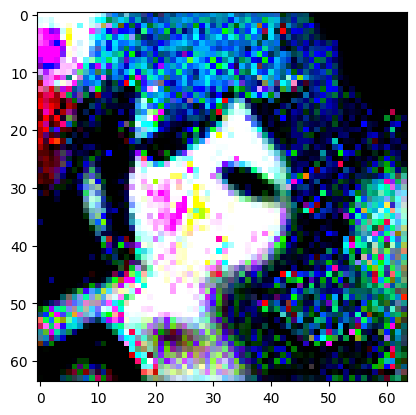

In [16]:
inference(model, device)

In [ ]:
x_0 = torch.rand(10,3,128,128).numpy()
t = torch.range(1,10)
print(t.shape)
sg, ns = forward_noise(0,x_0,t)
print(sg.shape)
print(ns.shape)